<span style="color: blue;">
<br><br><br>
<h1><center>Groceries</center></h1>
<h2><center>What is the most popular pairing of products?<br>What is the best predictive model?</center></h2>
<br><br>
<h3><center>A Report by Cathal<h3></center>
<br><br><br>
</span>

<span style="color: blue;">
<h1><left> Table of contents<h1><left>
</span>

<span style="color: red;">
<h3><left>Introduction
<br><br>
<h3><left>Data Preparation
<br><br>
<h3><left>Encoding
<br><br>
<h3><left>Market Basket Analyis
<br><br>
<h3><left>Making Predictions
<br><br>
<h3><left>Conclusion
<br><br>
<h3><left>References</h3></left>
<br><br>
</span>

<span style="color: blue;">
<br><br>   
<h1><center>Introduction</center></h1>
<br><br>
</span>

We have a dataset of groceries bought by people with membership cards from 2015. Firstly, we’ll import the relevant libraries for the analysis and feed the dataset into a dataframe called groceries_df. 

In [1]:
# import all the necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from datetime import datetime
groceries_df=pd.read_csv("groceries.csv") #import the groceries dataset into a dataframe

The data contains the following variables:

In [2]:
groceries_df.info() #makeup of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
 3   year             38765 non-null  int64 
 4   month            38765 non-null  int64 
 5   day              38765 non-null  int64 
 6   day_of_week      38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


<span style="color: blue;">
<br><br>   
<h1><center>Data Preparation</center></h1>
<br><br>
</span>

To do an effective Market Basket Analysis, the data cannot contain null values, plentiful supply of unique items and no rows where the shopper didn’t buy anything but their use of the membership card was recorded.Firsltly, let’s see if there is any null values.


In [3]:
groceries_df.isna().sum() # check for null values

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

We have no null values. Now, let’s check for unique items.

In [4]:
groceries_df.nunique(axis=0)

Member_number      3898
Date                728
itemDescription     167
year                  2
month                12
day                  31
day_of_week           7
dtype: int64

In [5]:
groceries_df['itemDescription'].unique()

array(['tropical fruit', 'whole milk', 'pip fruit', 'other vegetables',
       'rolls/buns', 'pot plants', 'citrus fruit', 'beef', 'frankfurter',
       'chicken', 'butter', 'fruit/vegetable juice',
       'packaged fruit/vegetables', 'chocolate', 'specialty bar',
       'butter milk', 'bottled water', 'yogurt', 'sausage', 'brown bread',
       'hamburger meat', 'root vegetables', 'pork', 'pastry',
       'canned beer', 'berries', 'coffee', 'misc. beverages', 'ham',
       'turkey', 'curd cheese', 'red/blush wine',
       'frozen potato products', 'flour', 'sugar', 'frozen meals',
       'herbs', 'soda', 'detergent', 'grapes', 'processed cheese', 'fish',
       'sparkling wine', 'newspapers', 'curd', 'pasta', 'popcorn',
       'finished products', 'beverages', 'bottled beer', 'dessert',
       'dog food', 'specialty chocolate', 'condensed milk', 'cleaner',
       'white wine', 'meat', 'ice cream', 'hard cheese', 'cream cheese ',
       'liquor', 'pickled vegetables', 'liquor (appetizer

Let’s ensure that the itemDescription variable always contains an actual item. Let’s see do any contain the words “None”. 

In [6]:
groceries_df.loc[(groceries_df['itemDescription']=="NONE")]

,Member_number,Date,itemDescription,year,month,day,day_of_week


None do. We can safely do a Market Basket Analysis on this data. Firstly, let’s have a look at what the most popular products are:

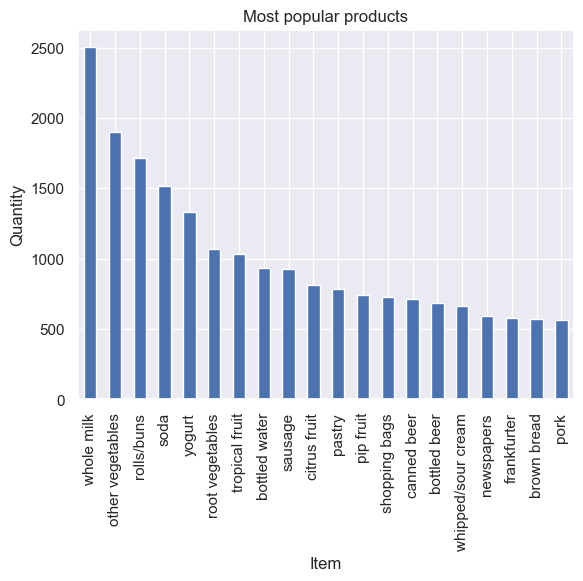

In [7]:
top_20_products=groceries_df.value_counts("itemDescription").head(20)
top_20_products.plot(kind="bar",title="Most popular products", xlabel="Item", ylabel="Quantity");

When we do the most popular pairs of products bought later, this output will give us an idea of what it should contain. We can see that milk is the most popular product followed by vegetables and rolls/buns.

<span style="color: blue;">
<br><br>   
<h1><center>Encoding the data</center></h1>
<br><br>
</span>

The data contains Member number, date, the date broken down into individual parts, day of week and the item bought. It doesn’t contain quantities bought, so we will need to do something creative there. 
There is a thread on the internet where a new variable was made that combines the member number and the date bought (Selvaraj, 2023). The idea behind it was to create individual instances of items bought. However, after extensive testing of this and using a variety of variables for the intersection points, the output it produced firstly didn’t tie in with what are the most popular products but also it was very sensitive where a small change in one of the parameters produced an entirely different set of results. So, let’s start with making a new dataframe that contains the Member number, date and item description. We’ll give it the name groceries_df_basket.


In [8]:
groceries_df_basket=groceries_df.drop(['year','month','day','day_of_week'], axis=1) # drop unnecessary columns

groceries_df_basket

,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-05-01,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-01-02,whole milk
...,...,...,...
38760,4471,2014-08-10,sliced cheese
38761,2022,2014-02-23,candy
38762,1097,2014-04-16,cake bar
38763,1510,2014-03-12,fruit/vegetable juice


Now we need to create a grid which records what the member bought and when they bought it. As the data doesn’t contain quantities bought, we can make a grid of the member number on the y axis, the item bought on the x axis, and where the two intersect, we can insert the date bought. This will record each time an item was bought by a member. We would have to assume that in each instance, a quantity of 1 was bought on the specific date. 

In [9]:
groceries_basket = groceries_df_basket.groupby(['Member_number','itemDescription'])['Date'].sum().unstack().reset_index().fillna(0).set_index('Member_number')
groceries_basket

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2015-03-152014-06-24,2015-03-15,0
1001,0,0,0,0,0,0,0,0,2015-04-14,0,...,0,0,0,2015-01-20,0,2015-04-14,0,2014-12-122014-07-02,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2014-04-26,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2014-10-132014-04-022014-08-19,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2015-12-27,2014-05-01,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we need to encode it.
The market basket analysis cannot use date as a metric, so we need to substitute in values. The values themselves have to be between 0 and 1, even where an intersection contains more than one date. So, where the intersection happens, a value of 1 is inserted, regardless of how many dates there are in the intersection. We’ll give the output the name groceries_basket_encode.

In [10]:
def encode_units(x):
    if x == 0:
        return 0
    if x != 0:
        return 1
groceries_basket_encode = groceries_basket.applymap(encode_units)
groceries_basket_encode

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<span style="color: blue;">
<br><br>   
<h1><center>Market Basket Analysis</center></h1>
<br><br>
</span>

Note that some of the itemsets contain 2 values from itemDescription. As we are only looking for single items, bought together, we need to set the min_support parameter later to only pickup single items.
Now we can start the Apriori analysis. This will provide us with a support figure that should align with the most popular products and provide a list of the most frequent items bought. We can see the top 20 products align with the graph from earlier.

In [11]:
groceries_basket_frequent_item = apriori(groceries_basket_encode, min_support=0.1,
use_colnames=True).sort_values('support',ascending=False).reset_index(drop=True)
groceries_basket_frequent_item['length'] = groceries_basket_frequent_item['itemsets'].apply(lambda x: len(x))
groceries_basket_frequent_item

C:\Users\donne\AppData\Roaming\Python\Python38\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,length
0,0.458184,(whole milk),1
1,0.376603,(other vegetables),1
2,0.349666,(rolls/buns),1
3,0.313494,(soda),1
4,0.282966,(yogurt),1
5,0.233710,(tropical fruit),1
6,0.230631,(root vegetables),1
7,0.213699,(bottled water),1
8,0.206003,(sausage),1
9,0.191380,"(other vegetables, whole milk)",2


We can now look at the most popular pairs of items. We use the association rules algorithm from the Mlxtend library. 
In order to get a true output, it is necessary to try out different values of min_support to ensure that only individual products appear within the pairings. A min_support figure of 0.9 produced no results. A figure of 0.01 produced results where 3 different products appeared as a single pair. Ultimately, a figure of 0.1 produced results that showed an output only composed of individual products.

In [12]:
items_bought_together=association_rules(groceries_basket_frequent_item, metric='lift',min_threshold=1).sort_values(['lift'], ascending=False).reset_index(drop=True)
items_bought_together

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(whole milk),(yogurt),0.458184,0.282966,0.150590,0.328667,1.161510,0.020940,1.068076,0.256640
1,(yogurt),(whole milk),0.282966,0.458184,0.150590,0.532185,1.161510,0.020940,1.158185,0.193926
2,(bottled water),(whole milk),0.213699,0.458184,0.112365,0.525810,1.147597,0.014452,1.142615,0.163569
3,(whole milk),(bottled water),0.458184,0.213699,0.112365,0.245241,1.147597,0.014452,1.041790,0.237376
4,(sausage),(whole milk),0.206003,0.458184,0.106978,0.519303,1.133394,0.012591,1.127146,0.148230
5,(whole milk),(sausage),0.458184,0.206003,0.106978,0.233483,1.133394,0.012591,1.035850,0.217222
6,(yogurt),(other vegetables),0.282966,0.376603,0.120318,0.425204,1.129050,0.013752,1.084553,0.159406
7,(other vegetables),(yogurt),0.376603,0.282966,0.120318,0.319482,1.129050,0.013752,1.053660,0.183350
8,(rolls/buns),(yogurt),0.349666,0.282966,0.111339,0.318415,1.125279,0.012396,1.052011,0.171191
9,(yogurt),(rolls/buns),0.282966,0.349666,0.111339,0.393472,1.125279,0.012396,1.072224,0.155267


This output provides us with the first and second items bought and a series of metrics that determine the likelihood of these products being chosen during a visit. The first thing to note is that for each combination of products, they alternate as antecedent and consequent items. For example, the top pair of whole milk and yogurt as both antecedent and consequent items. In order to get the top 5 pairs of products, we need to look at the top 10 values on the output. The most popular product pairs are:

    1.	Milk and Yogurt
    2.	Milk and Bottled Water
    3.	Milk and Sausage
    4.	Yogurt and vegetables
    5.	Yogurt and Rolls/Buns

There is a few standout characteristics in this output:

    •	All pairs contain a dairy product, notably Milk and Yogurt
    •	The items in the most popular pairing each appear in subsequent pairings
    •	15% of the transactions involve yogurt and milk.
    •	Once the lift is greater than 1, that means these two items are likely to be bought together. In all instances, the lift is greater than 1.
    •	The support figure for milk is 45%. This indicates that any customer who comes in, there is a 45% chance that they will buy milk. 


<span style="color: blue;">
<br><br>   
<h1><center>Making predictions</center></h1>
<br><br>
</span>



Now let’s categorize the data. There are several techniques that can be used to categorize data, a few of them are simple and a few are complex. In order to make a good comparison, let’s use a complex one and a simple one: MultinomialNB from the Naïve Bayes library and DecisionTree. Both classification algorithms are particularly suited to attaching labels to text and thus would be appropriate to use again groceries data.
Firstly, let’s assign add a column called category and assign each value in itemDescription a value. We have a list of unique values the appear in the itemDescription variable from earlier. We can copy these and assign each one a category manually. Let’s assign 7 categories to a number of items and flag the rest as blank. 


In [13]:
groceries_df_basket['category']=''
categories={'tropical fruit':'fruit/veg','pip fruit':'fruit/veg','other vegetables':'fruit/veg','citrus fruit':'fruit/veg', 
'fruit/vegetable juice':'fruit/veg','potato products':'fruit/veg','packaged fruit/vegetables':'fruit/veg',
'root vegetables':'fruit/veg','frozen fruits':'fruit/veg','specialty vegetables':'fruit/veg','whole milk':'dairy','butter':'dairy',
'butter milk':'dairy','yogurt':'dairy','curd cheese':'dairy','processed cheese':'dairy',
'curd':'dairy','ice cream':'dairy', 'hard cheese':'dairy', 'cream cheese':'dairy','UHT-milk':'dairy',
'domestic eggs':'dairy','whipped/sour cream':'dairy','sliced cheese':'dairy','specialty cheese':'dairy',
'spread cheese':'dairy','margarine':'dairy','soft cheese':'dairy', 'mayonnaise':'dairy','cream':'dairy',
'condensed milk':'dairy','beef':'meat','frankfurter':'meat','chicken':'meat','sausage':'meat',
'hamburger meat':'meat','pork':'meat','ham':'meat','turkey':'meat','fish':'meat','frozen chicken':'meat',
'frozen fish':'meat','canned fish':'meat','organic sausage':'meat','meat spreads':'meat',
'bottled water':'beverage','coffee':'beverage','misc. beverages':'beverage','soda':'beverage',
'beverages':'beverage','tea':'beverage','instant coffee':'beverage','rubbing alcohol':'alcohol','liqueur':'alcohol',
'whisky':'alcohol','rum':'alcohol','brandy':'alcohol','prosecco':'alcohol','liquor (appetizer)':'alcohol','liquor':'alcohol',
'white wine':'alcohol','bottled beer':'alcohol','sparkling wine':'alcohol','red/blush wine':'alcohol','preservation products':'cosmetics',
'make up remover':'cosmetics','skin care':'cosmetics','male cosmetics':'cosmetics','baby cosmetics':'cosmetics',
'hygiene articles':'cosmetics','female sanitary products':'cosmetics','hair spray':'cosmetics','cake bar':'sweet',
'jam':'sweet','cocoa drinks':'sweet','nut snack':'sweet','snack products':'sweet',
'sweet spreads':'sweet','chocolate marshmallow':'sweet','frozen dessert':'sweet','candy':'sweet',
'chocolate':'sweet', 'specialty bar':'sweet','chewing gum':'sweet','toilet cleaner':'cleaning','abrasive cleaner':'cleaning',
'bathroom cleaner':'cleaning','house keeping products':'cleaning','detergent':'cleaning','cleaner':'cleaning',
'dish cleaner':'cleaning'}
groceries_df_basket['category'] = groceries_df_basket['itemDescription'].map(categories)
groceries_df_basket['category']=groceries_df_basket['category'].fillna('')
groceries_df_basket

,Member_number,Date,itemDescription,category
0,1808,2015-07-21,tropical fruit,fruit/veg
1,2552,2015-05-01,whole milk,dairy
2,2300,2015-09-19,pip fruit,fruit/veg
3,1187,2015-12-12,other vegetables,fruit/veg
4,3037,2015-01-02,whole milk,dairy
...,...,...,...,...
38760,4471,2014-08-10,sliced cheese,dairy
38761,2022,2014-02-23,candy,sweet
38762,1097,2014-04-16,cake bar,sweet
38763,1510,2014-03-12,fruit/vegetable juice,fruit/veg


Now, lets split the train and test data along the lines of category using category as the target variable. We’ll run the MultinominalNB algorithm first. 

In [14]:
count_vect = CountVectorizer()
counts=count_vect.fit_transform(groceries_df_basket['itemDescription'])
transformer = TfidfTransformer().fit(counts)
counts = transformer.transform(counts)
X_train, X_test, y_train, y_test = train_test_split(counts, (groceries_df_basket['category']), test_size=0.5, random_state=60)
model = MultinomialNB().fit(X_train, y_train)
predicted = model.predict(X_test)
print(np.mean(predicted==y_test))

0.9713150699066192


After compiling, we’ve got an accuracy score of 97.1%, which is quite acceptable for this algorithm. Now, let’s plot the confusion matrix.

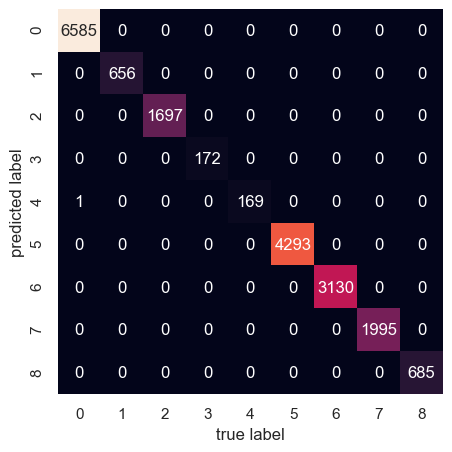

In [19]:
prediction=confusion_matrix(y_test, predicted)
prediction
plt.figure(figsize=(16,5))
sns.heatmap(prediction, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In categorisation outputs, values along the diagonal represent instances where the predicated label matches the true label. As most values are along the diagonal, it means the MultinomiaNB would appear to accurately predict the values in the test dataset compared with the train dataset. Now let’s use the DecisionTree algorithm. The test and train split are the same. 


In [16]:
dt = DecisionTreeClassifier()
dt_model=dt.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
predicted = dt_model.predict(X_test)
print(np.mean(predicted==y_test))

0.9999484083991126


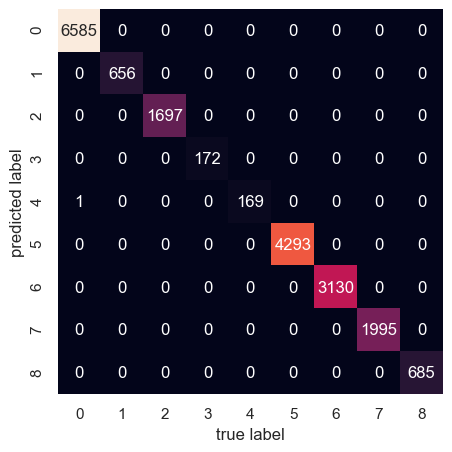

In [17]:
dt_prediction=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,5))
sns.heatmap(dt_prediction, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

After compiling, we’ve got an amazing accuracy score of 99.9%. Also, after plotting the output, we can see all values are along the diagonal with 1 outside it.
The DecisionTree algorithm is more accurate than the MultinomiaNB.

<span style="color: blue;">
<br><br>   
<h1><center>Conclusion</center></h1>
<br><br>
</span>

The dataset is a simple one containing a Member Number, Date, date components broken down and the item bought. As a result, the most accurate algorithm to use is a simple one. The complex algorithm is less accurate at predicting the category of item bought.

The Market Basket Analysis indicates that in this store that dairy products are among the most popular bought followed by vegetables, buns and beverages. This would indicate that while 3 of those items would be considered “unhealthy”, 1 of them is part of a balanced diet. 

On the most popular products in general, there is a balance between “healthy” and “unhealthy” products. This can be used by the store in question to look at the floor layout and optimise it accordingly.

Both algorithms are quite sensitive to a minimum support parameter with small changes producing very different outputs for the pairing of products.  


<span style="color: blue;">
<br><br>   
<h1><center>References</center></h1>
<br><br>
</span>


Selvaraj, N., 2023. How to Perform Market Basket Analysis in Python. [Online] 
Available at: https://365datascience.com/tutorials/python-tutorials/market-basket-analysis/
[Accessed 29th May 2023].

